In [1]:
 #load Raw data from TDT ECoG maschine, plz run ""
import numpy as np
import scipy.io as scio
from scipy import signal
import tdt
import os
import  wave
import matplotlib.pyplot as plt
import json
from scipy.fftpack import fft
from random import shuffle
import h5py
import scipy.io as scio
import scipy.io.wavfile
import math
import mne
import torch   
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import random_split

In [2]:
PATH='/public/DATA/overt_reading/'
HS_list=[65]

In [3]:
PATH='/public/DATA/overt_reading/points'
cue_points=np.load(os.path.join(PATH,'HS86_oneset_cue_point.npy'),allow_pickle=True)
read_point=np.load(os.path.join(PATH,'HS86_onset_read_time.npy'),allow_pickle=True)
delay=np.load(os.path.join(PATH,'HS86_delay_list.npy'),allow_pickle=True)

/root/anaconda3/envs/ecog/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


In [4]:
cue_points

array({'0': tensor([111761, 116261, 120761, 125260, 129760, 134260, 138760, 143259, 147759,
        152259, 158792, 163291, 167791, 172291, 176791, 181290, 185790, 190290,
        194790, 199289, 205822, 210322, 214822, 219321, 223821, 228321, 232821,
        237320, 241820, 246320, 252853, 257352, 261852, 266352, 270852, 275351,
        279851, 284351, 288851, 293350, 299883, 304383, 308883, 313383, 317882,
        322382, 326882, 331381, 335881, 340381, 346914, 351414, 355913, 360413,
        364913, 369413, 373912, 378412, 382912, 387411]), '1': tensor([101029, 105529, 110029, 114529, 119028, 123528, 128028, 132528, 137027,
        141527, 148060, 152560, 157059, 161559, 166059, 170559, 175058, 179558,
        184058, 188558, 195091, 199590, 204090, 208590, 213089, 217589, 222089,
        226589, 231088, 235588, 242121, 246621, 251121, 255620, 260120, 264620,
        269119, 273619, 278119, 282619, 289152, 293651, 298151, 302651, 307151,
        311650, 316150, 320650, 325150, 32964

In [6]:
read_point

array({'0': tensor([113761, 118261, 122760, 127260, 131760, 136260, 140759, 145259, 149759,
        154259, 160792, 165291, 169791, 174291, 178790, 183290, 187790, 192290,
        196789, 201289, 207822, 212322, 216822, 221321, 225821, 230321, 234821,
        239320, 243820, 248320, 254853, 259352, 263852, 268352, 272852, 277351,
        281851, 286351, 290851, 295350, 301883, 306383, 310883, 315382, 319882,
        324382, 328882, 333381, 337881, 342381, 348914, 353413, 357913, 362413,
        366913, 371412, 375912, 380412, 384912, 389411]), '1': tensor([103029, 107529, 112029, 116529, 121028, 125528, 130028, 134528, 139027,
        143527, 150060, 154560, 159059, 163559, 168059, 172559, 177058, 181558,
        186058, 190558, 197091, 201591, 206090, 210590, 215089, 219589, 224089,
        228589, 233088, 237588, 244121, 248621, 253120, 257620, 262120, 266620,
        271119, 275619, 280119, 284619, 291152, 295651, 300151, 304651, 309151,
        313650, 318150, 322650, 327149, 33164

In [7]:
delay

array({'0': tensor(-15282.4004), '1': tensor(192327.0469), '2': tensor(562143.4375), '3': tensor(335952.0938), '4': tensor(16595.4492), '5': tensor(10810.1504)},
      dtype=object)

In [4]:
def transfer(self, x, block):
        return int((int(x) * 24.414 - self.delay_list[str(block)]) / 24414 * 400)

In [5]:
def calculating_time(time,delay,freq):
    '''
    description: 根据delay计算新的时间点
    time：需要转换的时间字典dict：{'blockid': [time]}
    '''
    fs=24414
    # print(delay)
    time = time.cpu().numpy()
    time=time.astype(np.float64)
    delay/=fs
    time/=1000
    time-=delay
    time=time*(freq/2)
    return time.astype(int)

检查timeblock的形状是否符合要求

In [6]:
a=np.load('/public/DATA/overt_reading/processed_data/HS83/400/HS83-20231214-231214-115041.npy')
print(a.shape)

(256, 153366)


共有256个电极

In [11]:
len(a)

256

制作码表

In [8]:
def map_dist(dist):
    code_dist=[]
    for word in dist:
        if word=='功课':
            code_dist.append(10)
        elif word=='数页':
            code_dist.append(11)
        elif word=='宫客':
            code_dist.append(12)
        elif word=='shù yè':
            code_dist.append(13)
        elif word=='力果':
            code_dist.append(14)
        elif word=='对十':
            code_dist.append(15)
        elif word=='树叶':
            code_dist.append(16)
        elif word=='gōng kè':
            code_dist.append(17)
        elif word=='作业':
            code_dist.append(18)
        elif word=='绿草':
            code_dist.append(19)
    return code_dist


保存函数，后面可加入utils中

In [9]:
def np_save(nparr,path):
    if os.path.exists(path):
        os.remove(path)
    with open(path,'wb')as file:
        np.save(file,nparr)

In [10]:
b=a[184,:]
c=mne.time_frequency.stft(b,800,tstep=2)

NameError: name 'a' is not defined

In [15]:
c.shape

(1, 401, 76683)

In [16]:
d=c[0,:,0:400]

In [17]:
d.shape

(401, 400)

In [18]:
d=(d-np.mean(d,axis=1,keepdims=True))/np.std(d,axis=1,keepdims=True)

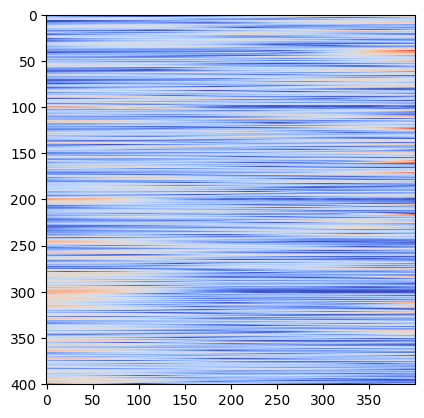

In [19]:
plt.imshow(np.abs(d),cmap='coolwarm',interpolation='nearest')
plt.show()

In [9]:
import numpy as np
cue = np.load('/public/DATA/overt_reading/points/HS68_oneset_cue_point.npy',allow_pickle=True).item()
# print(len(cue))
print(cue)
# processed = np.load('/public/DATA/overt_reading/processed_data/HS68/400/HS68-20230810-230810-113102.npy')
# print(len(processed))
# print(processed)

{'0': tensor([101990, 106490, 110990, 115490, 119989, 124489, 128989, 133489, 137988,
        142488, 149021, 153521, 158020, 162520, 167020, 171520, 176019, 180519,
        185019, 189519, 196085, 200585, 205084, 209584, 214084, 218584, 223083,
        227583, 232083, 236583, 243116, 247615, 252115, 256615, 261114, 265614,
        270114, 274614, 279113, 283613, 290146, 294646, 299146, 303645, 308145,
        312645, 317145, 321644, 326144, 330644, 337177, 341676, 346176, 350676,
        355176, 359676, 364175, 368675, 373175, 377674]), '1': tensor([110077, 114576, 119076, 123576, 128075, 132575, 137075, 141575, 146074,
        150574, 157107, 161607, 166107, 170606, 175106, 179606, 184106, 188605,
        193105, 197605, 204138, 208638, 213137, 217637, 222137, 226637, 231136,
        235636, 240136, 244635, 251168, 255668, 260168, 264668, 269167, 273667,
        278167, 282667, 287166, 291666, 298199, 302699, 307199, 311698, 316198,
        320698, 325197, 329697, 334197, 338697, 345

In [10]:
# from ecog_band.utils import calcu_spec

def splitAndSTFT(HS,PATH,freq_list,idx_elec,idx_block=0):
    path_time=os.path.join(PATH,'processed_data',f'HS{HS}')
    path_points=os.path.join(PATH,'points')

    cue=np.load(os.path.join(path_points,f'HS{HS}_oneset_cue_point.npy'),allow_pickle=True).item()#The files saved are all dics,so remeber to add item
    read=np.load(os.path.join(path_points,f'HS{HS}_onset_read_time.npy'),allow_pickle=True).item()#key is the block and value is the cue or read point (list) or the delay time(num)
    delays=np.load(os.path.join(path_points,f'HS{HS}_delay_list.npy'),allow_pickle=True).item()
    words=np.load(os.path.join(path_points,f'HS{HS}_words.npy'),allow_pickle=True).item()
    
    if isinstance(idx_elec, int):
        idx_elec = [idx_elec]
        
    for freq in freq_list:
        temp=os.path.join(path_time,str(freq))
        path = os.listdir(temp)
        # print(temp)
        # print(len(path))
        for z in range(idx_block, len(path)):
            if HS == 68 and z == 0:
                continue
            if HS == 79 and z==1:
                continue
            ecog_block=np.load(os.path.join(temp,path[z]))
            # print(ecog_block)
            # print(len(ecog_block))
            oneset_cue_point=cue[str(z)]
            onset_read_time=read[str(z)]
            delay=delays[str(z)]
            word=words[str(z)]
            task_label=map_dist(word)#list
            # print(oneset_cue_point)
            
            oneset_cue=calculating_time(oneset_cue_point,delay.item(),freq)
            read_time=calculating_time(onset_read_time,delay.item(),freq)
            
            time=np.zeros(ecog_block.shape[1])
            task_time=np.zeros(ecog_block.shape[1])

            # 给time数组onset_cue到onset_cue+freq/2的采样点标记为1，表示看
            # 给task_time数组onset_cue到onset_cue+freq/2的采样点标记为单词label，表示看哪个单词
            for cnt_for_words_cue,index in enumerate(oneset_cue):
                time[index : min(index + int(freq*0.75), len(time))]=1#time line with label,a 1 dim vector
                task_time[index :min(index + int(freq*0.75), len(task_time))]=task_label[cnt_for_words_cue]#10 word classification

            # 给time数组read_time到read_time+freq*0.75的采样点标记为2，表示读
            # 给task_time数组read_time到read_time+freq*0.75的采样点标记为单词label，表示读哪个单词
            for cnt_for_words_read,id in enumerate(read_time):
                time[id : min(id+int(id+freq*0.75), len(time))]=2
                task_time[id : min(id+int(id+freq*0.75), len(task_time))]=task_label[cnt_for_words_read]

            # 逐电极使用stft,将Ecog转化到频域，然后取time和task_time对应的时间点的数据，保存在dataset目录下 这样的话，就得到了每个被试在不同采样率的数据，且所有频段都有label
            for elec in idx_elec: 
                # print(f'electrode id :{elec}')
                print(f'This is freq:{freq},block:{z},elec:{elec}')
                data_block_cue=[]
                data_block_read=[]
                baseline_block_cue = []
                baseline_block_read = []
                # print(ecog_block.shape) # 一维时间信号 (256, 161485)
                ecog_block_seg=mne.time_frequency.stft(ecog_block[elec],2*freq,2) # 先使用stft处理数据 得到的seg shape = (n_elec, n_freq, n_time)
                # ecog_block_seg = calcu_spec(ecog_block)
                
                # ecog_block_seg=(ecog_block_seg-np.mean(ecog_block_seg[:,:,oneset_cue[0]:],axis=2,keepdims=True))/np.std(ecog_block_seg[:,:,oneset_cue[0]:],axis=2,keepdims=True)
                # print(ecog_block_seg.shape) # (1, 401, 76079)
                # print(ecog_block_seg.shape[2])
                for index in oneset_cue: # 取看的Ecog数据保存在data_block_cue
                    # print(ecog_block_seg[0,:,index:index+int(freq/2)])
                    stft_block_cue=ecog_block_seg[0,:,index:min(index+int(freq*0.75), ecog_block_seg.shape[2])]
                    cue_baseline = ecog_block_seg[0, :, max(0, index-int(freq*0.75)):index]
                    # print(f'stft_block_cue: {stft_block_cue.shape[1]}')
                    # print(cue_baseline.shape[1])
                    # print(index)
                    if stft_block_cue.shape[1]==int(freq*0.75) and cue_baseline.shape[1]==int(freq*0.75):
                        data_block_cue.append(stft_block_cue)#spectrum block with 256 elecs
                        baseline_block_cue.append(cue_baseline)
                # print(ecog_block_seg.shape[2])
                for id in read_time:# 取读的Ecog数据保存在data_block_read
                    stft_block_read=ecog_block_seg[0,:,id:min(id+int(freq*0.75), ecog_block_seg.shape[2])]
                    read_baseline = ecog_block_seg[0, :, max(0, id-int(freq*0.75)):id]
                    # print(id)
                    if stft_block_read.shape[1]==int(freq*0.75) and read_baseline.shape[1]==int(freq*0.75):
                        # print(stft_block_read.shape)
                        data_block_read.append(stft_block_read)
                        baseline_block_read.append(read_baseline)

                # print(len(data_block_read))
                data_block_cue=np.stack(data_block_cue)
                data_block_read=np.stack(data_block_read)
                task_label=np.array(task_label)
                baseline_block_cue = np.stack(baseline_block_cue)
                baseline_block_read = np.stack(baseline_block_read)
                os.makedirs(os.path.join(PATH,f'dataset_/HS{HS}',str(freq),str(elec)),exist_ok=True)
                path_elec=os.path.join(PATH,f'dataset_/HS{HS}',str(freq),str(elec))
                print('DONE')
                print(f'data_block_cue.shape:{data_block_cue.shape}')
                print(f'data_block_read.shape:{data_block_read.shape}')
                print(f'task_label.shape{task_label.shape}')
                print(f'baseline_block_cue.shape: {baseline_block_cue.shape}')
                print(f'baseline_block_read.shape: {baseline_block_read.shape}')
                # print(data_block_cue.shape,task_label.shape,data_block_read.shape)
                np_save(data_block_cue,os.path.join(path_elec,f'{z}_data_block_cue.npy'))
                np_save(data_block_read,os.path.join(path_elec,f'{z}_data_block_read.npy'))
                np_save(task_label,os.path.join(path_elec,f'{z}_data_label.npy'))
                np_save(baseline_block_cue, os.path.join(path_elec, f'{z}_baseline_block_cue.npy'))
                np_save(baseline_block_read, os.path.join(path_elec, f'{z}_baseline_block_read.npy'))

            # print(f'len(time): {len(time)}, len(time): {len(task_time)}')
            # np_save(time,os.path.join(PATH,f'dataset/HS{HS}',str(freq),f'{z}_time.npy'))
            # np_save(task_time,os.path.join(PATH,f'dataset/HS{HS}',str(freq),f'{z}_task_time.npy'))

In [11]:
PATH='/public/DATA/overt_reading/'
# freq_list=[400, 500, 1000]
freq_list = [500]
# HS_list = [69, 75, 82, 83, 84, 85, 86]
# HS_list = [68,] # 记住修改z的值 未完成
# HS_list = [83, 84, 85, 86]
HS_list = [69]
idx_elec = list(range(1, 256))
for HS in HS_list:
    print(f'Split for HS：{HS}')
    splitAndSTFT(HS, PATH, freq_list, 0)

Split for HS：69
This is freq:500,block:0,elec:0
Number of frequencies: 501
Number of time steps: 121332
DONE
data_block_cue.shape:(60, 501, 375)
data_block_read.shape:(60, 501, 375)
task_label.shape(60,)
baseline_block_cue.shape: (60, 501, 375)
baseline_block_read.shape: (60, 501, 375)
This is freq:500,block:1,elec:0
Number of frequencies: 501
Number of time steps: 100886
DONE
data_block_cue.shape:(60, 501, 375)
data_block_read.shape:(60, 501, 375)
task_label.shape(60,)
baseline_block_cue.shape: (60, 501, 375)
baseline_block_read.shape: (60, 501, 375)
This is freq:500,block:2,elec:0
Number of frequencies: 501
Number of time steps: 100803
DONE
data_block_cue.shape:(60, 501, 375)
data_block_read.shape:(60, 501, 375)
task_label.shape(60,)
baseline_block_cue.shape: (60, 501, 375)
baseline_block_read.shape: (60, 501, 375)
This is freq:500,block:3,elec:0
Number of frequencies: 501
Number of time steps: 99775
DONE
data_block_cue.shape:(60, 501, 375)
data_block_read.shape:(60, 501, 375)
task_l

后面可以对函数的参数进行解释

In [14]:
import numpy as np
import os
path_datast='/public/DATA/overt_reading/dataset'
b=np.load(os.path.join(path_datast,f'HS83','500','251',f'0_data_block_cue.npy'))
c=np.load(os.path.join(path_datast,f'HS86','500','7',f'elec7_0_data_block_cue.npy'))

In [16]:
b.shape # (60, 501, 250)
# c.shape # (60, 501, 375)

(60, 501, 250)